# Compressive Imaging with Deep Untrained Decoder Prior

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
from include import *
from PIL import Image
import PIL
import pywt
import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
from sklearn import linear_model

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
    device = 'cuda'
    if torch.cuda.device_count()==0:
        dtype = torch.FloatTensor
        device = 'cpu'
else:
    dtype = torch.FloatTensor
    device = 'cpu'
from scipy.fftpack import dct
from scipy.fftpack import idct
from scipy import io as sio 
import time

num GPUs 0


# Load image and pre-process

In [2]:
#dataset = 'mnist' # 'mnist' or 'celeba'
dataset = 'celeba'
path = './test_data/' + dataset + '/' 
img_name = dataset + '1' # 1-5 (for celeba), 1-6 (for mnist)
img_path = path + img_name + ".jpg"
img_pil = Image.open(img_path)
#if dataset == 'celeba':
#    img_pil = img_pil.crop((60,80+20,60+64,80+84)) #crop to 3 x 64 x 64 (60,80+20,60+64,80+84)
    
if dataset == 'celeba':
    cx=89
    cy=121
    img_pil = img_pil.crop((cx-64, cy - 64, cx + 64, cy+64))

img_np = pil_to_np(img_pil)
print('Dimensions of input image:', img_np.shape)
img_np = img_np / np.max(img_np)
img_np_orig = 1*img_np

Dimensions of input image: (3, 128, 128)


### Display image x and convert to pytorch variable

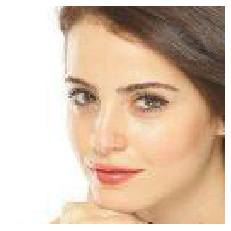

In [3]:
if dataset == 'celeba':
    plt.imshow(img_np.transpose(1,2,0))
else:
    plt.imshow(img_np[0,:,:])
    plt.gray()
plt.axis('off')
img_var = np_to_var(img_np).type(dtype)
d = img_np.shape[1]
out_ch = img_np.shape[0]
d_image = img_np.size

# Select and set up model to run - denoise, CS, PR 

In [4]:
#choose mode, 1 (denoising) , 2 (compressed sensing), 3 (phase retrieval)
mode = 1
if mode==1:
    f = 1 #(default)
    print('Compression/denoising mode')
    Ameas_var = 1
    img_var_meas = img_var
elif mode==2:
    print('Compressed sensing mode')
    f = 0.2 #compression rate
    print('Compression rate is ', f)
    m_image = int(f*d_image)
    print('Number of measurements is ',m_image, ' for signal of length ', d_image)
    # random Gaussian measurement matrix : A
    Ameas = np.random.randn(m_image,d_image).astype(float)/np.sqrt(m_image)
    Ameas_var = torch.from_numpy(Ameas).float().to(device)
    # measurements : y = A*x
    img_var_meas = torch.matmul(Ameas_var,img_var.to(device).reshape(d_image,1))
if mode==3:
    print('Compressed phase retrieval mode')    
    f = 0.6 #compression rate
    print('Compression rate is ', f)
    m_image = int(f*d_image)
    print('Number of measurements is ',m_image, ' for signal of length ', d_image)
    # random Gaussian measurement matrix : A    
    Ameas = np.random.randn(m_image,d_image).astype(float)/np.sqrt(m_image)
    Ameas_var = torch.from_numpy(Ameas).float().to(device)
    # full measurements : A*x
    img_var_meas = torch.matmul(Ameas_var,img_var.to(device).reshape(d_image,1))      
    # absolute valued measurements : y = |A*x|
    img_var_meas = torch.abs(img_var_meas)

Compression/denoising mode


# Define network

In [5]:
#use decoder architecture or DC GAN architecture
decodetype = 'upsample' # transposeconv / upsample

In [23]:
if dataset == 'mnist':
    num_channels = [25,15,10] 
elif dataset== 'celeba':    
    num_channels = [160,80,40,20,10] #[120,25,15,10] 
else:
    num_channels = [512,256,128]
output_depth = img_np.shape[0] # number of output channels
net = autoencodernet(num_output_channels=output_depth,num_channels_up=num_channels,need_sigmoid=True, Ameas=Ameas_var,
                        decodetype=decodetype
                        ).type(dtype)

print("number of parameters: ", num_param(net))
if decodetype == 'upsample':
    print(net.decoder)
elif decodetype == 'transposeconv':
    print(net.convdecoder)
net_in = copy.deepcopy(net)

#print(net)

n_scales= 5 num_channels_up= [160, 80, 40, 20, 10]
number of parameters:  35270
Sequential(
  (dconv0): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(160, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu0): ReLU()
  (dbn0): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups0): Upsample(scale_factor=2.0, mode=bilinear)
  (dconv1): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(80, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu1): ReLU()
  (dbn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups1): Upsample(scale_factor=2.0, mode=bilinear)
  (dconv2): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(40, 20, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu2): ReLU()
  (dbn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups2): Upsample(scale_factor=2.0, mode=bilinear)
  (dcon

# Invert Image from Measurements with Deep Network Prior

In [27]:
#pick optimization procedure
optim = 'gd'             #'pgd' (projected gradient descent), 'gd' (gradient descent)
if optim == 'pgd':
    optimizer2='SGD'      #outer loop optimizer - 'SGD' (or try 'adam')
    numit = 1000          #number of outer iterations of LS
    LR_LS = 10            #typically 5-10 ; required for outer loop of LS

    OPTIMIZER='SGD'       #inner loop optimizer - SGD or adam
    numit_inner = 10      #number of inner loop iterations for projection
    LR = 0.5             #typically 0.02-0.05 for pgd/inner loop of projection, higher for more complex structures

    lr_decay_epoch = 500  #decay learning rates of both inner and outer optimizers
    
elif optim == 'gd':
    OPTIMIZER='adam'       #optimizer - SGD or adam 
    numit = 10000         #number of iterations for SGD
    LR = 0.0002              #typically 0.02-0.5 for gd , higher for more complex structures

    optimizer2 = None                                    
    numit_inner = None
    LR_LS = None

    lr_decay_epoch = 3000
    
t0 = time.time()
mse_t, ni, net, ni_mod, in_np_img = fit( 
                            net=net,
                            num_channels=num_channels,
                            num_iter=numit,
                            numit_inner = numit_inner,
                            LR=LR,
                            LR_LS = LR_LS,
                            OPTIMIZER = OPTIMIZER,                         
                            optimizer2 = optimizer2,             
                            lr_decay_epoch = lr_decay_epoch,            
                            img_clean_var=img_var_meas,
                            find_best=True,
                            Ameas = Ameas_var,
                            model = mode,
                            code='uniform',
                            decodetype=decodetype,
                            optim=optim,
                            out_channels=out_ch        
                            )
t1 = time.time()
print('\ntime elapsed:',t1-t0)

shape of latent code B1:  [1, 160, 8, 8]
initializing latent code B1...
not optimizing over latent code Z1
optimize decoder with adam 0.0002
optimizing with gradient descent...

LR is set to 0.0002


Iteration 02999   Train loss 0.001298  
LR is set to 0.00014


Iteration 05999   Train loss 0.001052  
LR is set to 9.8e-05


Iteration 08999   Train loss 0.000992   
LR is set to 6.859999999999999e-05


Iteration 09999   Train loss 0.000952  
time elapsed: 232.51152563095093


# Plot loss

In [1]:
plt.xlabel('optimizer iteration')
plt.ylabel('loss')
plt.loglog(mse_t)

NameError: name 'plt' is not defined

# Compute initialization error

In [ ]:
lvls = len(num_channels)
if decodetype == 'upsample':
    nettype = net.decoder
    netintype = net_in.decoder
elif decodetype == 'transposeconv':
    nettype = net.convdecoder
    netintype = net_in.convdecoder
ComputeInitErr(nettype,netintype,lvls)

# Display reconstructed image and statistics

In [25]:
out_img_np = net( ni_mod.type(dtype) ).data.cpu().numpy()[0]

Image inversion with Deep-Decoder, SNR: 27.853689115367736
MSE: 0.0027344092


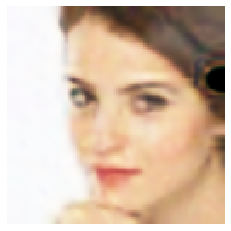

In [26]:
maxv = np.max(img_np) 
print("Image inversion with Deep-Decoder, SNR: " + str(psnr(img_np_orig,out_img_np,maxv)))  
reconstruction_err = mse(img_np_orig,out_img_np,maxv)
print('MSE:',reconstruction_err)
if dataset == 'celeba':
    plt.imshow(out_img_np.transpose(1,2,0))
else:
    plt.imshow(out_img_np[0,:,:])
plt.axis('off')
plt.show()
save_path= optim+'_'+img_name+str(int(10*f))+'.png'
savefig=False
if savefig:
    plt.savefig(save_path,bbox_inches='tight') 

## Display initialization and statistics

In [ ]:
in_img = in_np_img.data.cpu().numpy()
maxv = np.max(img_np) 
print("Image at random initialization of Deep-Decoder, SNR: " + str(psnr(img_np_orig,in_img,maxv)))  
reconstruction_err = mse(img_np_orig,in_img,maxv)
print('MSE:',reconstruction_err)
if dataset == 'celeba':
    plt.imshow(in_img[0,:,:,:].transpose(1,2,0))
else:
    plt.imshow(in_img[0,0,:,:])
plt.axis('off')
plt.show()
init_err = np.linalg.norm(out_img_np-in_img)/np.linalg.norm(out_img_np)
print('Initialization error:', init_err)

# Image inversion with sparsity priors

## Pick sparsifying basis - Compute wavelet or cosine transforms operators

In [ ]:
basis = 'DCT'              # spatial, DWT, DCT
if basis == 'DWT': #wavelet transform
    Winv = construct_Wminv(d=img_np.shape[1],wave_name='db1') #imported from wavelet_DCT_basis.py
    d_wav_image = int(np.sqrt(Winv.shape[1]))
    print('Size of image:', img_np.size, ', size of wavelet transform matrix:', Winv.shape)
elif basis == 'DCT': #DCT transform    
    Dinv = construct_IDCT2mat(d=d)                            #imported from wavelet_DCT_basis.py

## Modify measurement operator to incorporate transform 

In [ ]:
dsize = img_np.shape[1]*img_np.shape[2]
if not (mode==1):
    A = Ameas
    if basis=='DWT': #wavelet
        dwsize = Winv.shape[1]
        Aeff = np.zeros((Ameas.shape[0],dwsize*out_ch))
        for i in range(img_np.shape[0]):   
            Anew = np.dot(A[:,i*dsize:(i+1)*dsize],Winv)
            Aeff[:,i*dwsize:(i+1)*dwsize] = Anew
    elif basis=='DCT': #DCT
        Aeff = np.zeros((Ameas.shape[0],dsize*out_ch))
        for i in range(img_np.shape[0]):   
            Aeff[:,i*dsize:(i+1)*dsize] = np.dot(A[:,i*dsize:(i+1)*dsize],Dinv)    
    else:    
        Aeff = A
    y = img_var_meas.detach().cpu().numpy()
elif mode==1:
    Aeff = np.identity(np.ravel(img_var.cpu()).shape[0])
    y = np.ravel(img_var.cpu())

## Store measurements and operator for MATLAB codes

In [ ]:
#used for comparisons - TVAL3, SPARTA (supplementary code not provided in current version, will be updated)
if not (mode==1):
    save_mat = True
    if save_mat:
        sio.savemat('A.mat', {'A':Aeff})
        sio.savemat('y.mat', {'y':y})
        sio.savemat('xtrue.mat',{'x_':np.ravel(img_np)})

In [ ]:
if not (mode==1):
    img_vec = sio.loadmat('xtrue.mat')['x_']
    #img_vec = -img_vec

In [ ]:
if not (mode==1):
    if basis=='DWT': #wavelet
        img_vec = np.reshape(img_vec,[img_np.shape[0],dwsize])
        img_rec = np.zeros(img_np.shape)
        for i in range(img_np.shape[0]):    
            img_vec2 = np.dot(Winv,img_vec[i,:].T)
            img_rec[i,:,:] = np.reshape(img_vec2,[img_np.shape[1],img_np.shape[2]])    
    elif basis=='DCT': #DCT
        img_vec = np.reshape(img_vec,[img_np.shape[0],dsize])
        img_rec = np.zeros(img_np.shape)
        for i in range(img_np.shape[0]):    
            img_vec2 = np.dot(Dinv,img_vec[i,:].T)
            img_rec[i,:,:] = np.reshape(img_vec2,[img_np.shape[1],img_np.shape[2]])                
    else:
        img_rec = np.reshape(img_vec,img_np.shape)

In [ ]:
img_vec.shape

# Compressed sensing and denoising with Lasso

In [ ]:
if mode==1 or mode==2:
    t0 = time.time()
    reg = linear_model.Lasso(alpha=1e-6) #(max_iter=10000, fit_intercept=False, tol=0.00001)
    reg.fit(Aeff, y)  
    img_vec = reg.coef_
    if mode==2:
        if basis=='DWT':
            img_vec = np.reshape(img_vec,[img_np.shape[0],dwsize])
            img_rec = np.zeros(img_np.shape)
            for i in range(img_np.shape[0]):    
                img_vec2 = np.dot(Winv,img_vec[i,:].T)
                img_rec[i,:,:] = np.reshape(img_vec2,[img_np.shape[1],img_np.shape[2]])    
        elif basis=='DCT':
            img_vec = np.reshape(img_vec,[img_np.shape[0],dsize])
            img_rec = np.zeros(img_np.shape)
            for i in range(img_np.shape[0]):    
                img_vec2 = np.dot(Dinv,img_vec[i,:].T)
                img_rec[i,:,:] = np.reshape(img_vec2,[img_np.shape[1],img_np.shape[2]])                
        else:
            img_rec = np.reshape(img_vec,img_np.shape)
    else:
        img_rec = np.reshape(img_vec,img_np.shape)
    t1 = time.time()
    print('Time taken for Lasso:',t1-t0)            

## Display reconstructed image and statistics

In [ ]:
if mode==1 or mode==2:
    maxi = np.max(img_rec) 
    print("Image inversion with Lasso, SNR: " + str(psnr(img_np_orig,img_rec,maxi))) 
    reconstruction_err = mse(img_np_orig,img_rec,maxi)
    print('MSE:',reconstruction_err)
    if out_ch==3:
        plt.imshow(img_rec.transpose(1,2,0))
    else: 
        plt.imshow(np.clip(img_rec[0,:,:],0,1))
        plt.gray()
    plt.axis('off') 
    plt.show()  
    save_path= 'lasso_'+img_name+str(int(10*f))+'.png'
    savefig=False
    if savefig:
        plt.savefig(save_path,bbox_inches='tight') 